In [1]:
WORKER_COUNT = 8

In [2]:
# Sync models
# gsutil -m rsync -r /mnt/seals/models/ gs://thesis-penguins/models/ 
# aws s3 sync /mnt/seals/models s3://thesisvids/penguins/models/

In [3]:
# whether to log each feature and sequence status
verbose = True

In [4]:
import gc
import os
import pandas as pd
pd.options.display.max_rows = 5000
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt
import itertools
import sys
sys.path.append('..')

In [5]:
# setup paths
pwd = os.getcwd().replace("notebooks","")
path_cache = pwd + 'cache/'
path_data = pwd + 'data/'
path_models = pwd + 'models/'

In [6]:
# setup logging
# any explicit log messages or uncaught errors to stdout and file /logs.log
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(pwd, "logs")),
        logging.StreamHandler()
    ])
# init logger
logger = logging.getLogger()
# make logger aware of any uncaught exceptions
def handle_exception(exc_type, exc_value, exc_traceback):
    if issubclass(exc_type, KeyboardInterrupt):
        sys.__excepthook__(exc_type, exc_value, exc_traceback)
        return

    logger.error("Uncaught exception", exc_info=(exc_type, exc_value, exc_traceback))
sys.excepthook = handle_exception

In [7]:
from deepvideoclassification.pretrained_CNNs import pretrained_model_names, pretrained_model_names_bucketed

Using TensorFlow backend.


# Helper functions

In [8]:
def get_results():
    """
    Load the results of all completed models into a dataframe and return sorted on val_acc
    """

    results = []

    for folder, subs, files in os.walk(path_models):
        for filename in files:
            if 'results.json' in filename:
                with open(os.path.abspath(os.path.join(folder, filename))) as f:
                    data = json.load(f)
                results.append(data)

    results = pd.DataFrame(results)        
    results.sort_values("fit_val_acc", inplace=True, ascending=False)
    return results

In [9]:
def remove_completed_experiments(experiments):
    """
    Helper function to remove the completed experiments from experiments dataframe
    """
    
    # get updated result set
    results = get_results()
    
    # merge results onto experiments
    experiments = pd.merge(experiments, results[['model_id','fit_val_acc']], left_on='model_id', right_on='model_id', how='left')
    experiments['done'] = (experiments['fit_val_acc']>0).astype(int)
    print("{}/{} experiments done".format(experiments[experiments['done'] == 1].shape[0], len(experiments)))
    
    # only keep experiments not done
    experiments = experiments[experiments['done'] == 0]

    # clean up
    del experiments['done']
    del experiments['fit_val_acc']
    
    # return experiments already done
    return experiments

In [10]:
def reassign_workers(experiments):
    """
    Helper function to reassign outstanding experiments to workers
    """
    
    
    # get updated result set
    results = get_results()
    
    # merge results onto experiments
    experiments = pd.merge(experiments, results[['model_id','fit_val_acc']], left_on='model_id', right_on='model_id', how='left')
    experiments['done'] = (experiments['fit_val_acc']>0).astype(int)
    
    # reassign workers
    global todo_idx
    todo_idx = 0
    
    def assign_not_done_to_worker(row):
        """ helper lambda"""
        global todo_idx
        if row['done'] == 0:
            todo_idx+=1
            return todo_idx % WORKER_COUNT
        else:
            return 0
    
    experiments['WORKER'] = experiments.apply(assign_not_done_to_worker, axis=1)
    
    # clean up
    del experiments['done']
    del experiments['fit_val_acc']
    
    return experiments

# Create list of experiments to be run

* batch 1 = run frozen image MLP, LRCNNs and concat models on 1 of each pretrained_model_name in buckets (bucketed on feature sizes and limited to max sequence_length of 10)

* batch 2 = for best configurations from batch 1, run other pretrained models in buckets and run longer sequence lengths, maybe try different convolution kernel sizes

* batch 3 = run trainable MLP and LRCNN on best performing frozen variants

* batch 4 = run trainable but initializing with best CNN weights

* batch 5 = run C3D models

* batch 6 = analyze effect of dropout and pooling with best model

# Batch 1

In [ ]:
experiment_batch_name = 'experiment_batch_1'

In [ ]:
# init model id - need to make sure we pick up where we leave off don't overwrite it between batches
model_id_start = 0

In [ ]:
# init list of experiments
experiments = []

In [ ]:
pooling = 'max'
layer_sizes = [512, 256, 128, 0]
dropouts = [0.2]
sequence_lengths = [3,5,10]
sequence_models = ["LSTM", "SimpleRNN", "GRU", "Convolution1D"]
sequence_model_layer_counts = [1,2]

In [ ]:
####################
### image_MLP_frozen 
####################

for pretrained_model_name in pretrained_model_names_bucketed:
    for layer_1_size in layer_sizes:
        for layer_2_size in layer_sizes:
            for layer_3_size in layer_sizes:
                for dropout in dropouts:

                    # build experiment parameters
                    experiment = {}
                    
                    experiment['architecture'] = 'image_MLP_frozen'
                    experiment['sequence_length'] = 1
                    experiment['pretrained_model_name'] = pretrained_model_name
                    experiment['layer_1_size'] = layer_1_size
                    experiment['layer_2_size'] = layer_2_size
                    experiment['layer_3_size'] = layer_3_size
                    experiment['dropout'] = dropout
                    experiment['pooling'] = 'max' # outperforms avg across all parameters
                    
                    # add to list of experiments
                    experiments.append(experiment)

In [ ]:
####################
### video_MLP_concat
####################

for sequence_length in sequence_lengths:
    for pretrained_model_name in pretrained_model_names_bucketed:
        for layer_1_size in layer_sizes:
            for layer_2_size in layer_sizes:
                for layer_3_size in layer_sizes:
                    for dropout in dropouts:

                        # build experiment parameters
                        experiment = {}

                        experiment['architecture'] = 'video_MLP_concat'
                        experiment['pretrained_model_name'] = pretrained_model_name
                        experiment['layer_1_size'] = layer_1_size
                        experiment['layer_2_size'] = layer_2_size
                        experiment['layer_3_size'] = layer_3_size
                        experiment['dropout'] = dropout
                        experiment['pooling'] = 'max' # outperforms avg across all parameters
                        experiment['sequence_length'] = sequence_length

                        # add to list of experiments
                        experiments.append(experiment)

In [ ]:
######################
### video_LRCNN_frozen
######################

for sequence_length in sequence_lengths:
    for pretrained_model_name in pretrained_model_names_bucketed:
        for layer_1_size in layer_sizes:
            for layer_2_size in layer_sizes:
                for layer_3_size in layer_sizes:
                    for dropout in dropouts:
                        for sequence_model in sequence_models:
                            for sequence_model_layers in sequence_model_layer_counts:

                                # build experiment parameters
                                experiment = {}

                                experiment['architecture'] = 'video_LRCNN_frozen'
                                experiment['pretrained_model_name'] = pretrained_model_name
                                experiment['layer_1_size'] = layer_1_size
                                experiment['layer_2_size'] = layer_2_size
                                experiment['layer_3_size'] = layer_3_size
                                experiment['dropout'] = dropout
                                experiment['pooling'] = 'max' # outperforms avg across all parameters
                                experiment['sequence_model'] = sequence_model
                                experiment['sequence_model_layers'] = sequence_model_layers
                                experiment['sequence_length'] = sequence_length

                                # add to list of experiments
                                experiments.append(experiment)

In [ ]:
########################
### convert to dataframe
########################

experiments = pd.DataFrame(experiments)

### create model id column for this experiment batch
model_id_list = list(range(0,len(experiments)))
experiments['model_id'] = model_id_list

# assign to workers
experiments['WORKER'] = experiments['model_id'].apply(lambda x: x % WORKER_COUNT)

In [ ]:
experiments.shape

In [ ]:
############################################
### remove invalid experiment configurations
############################################

# Just won't run experiments for those model_ids - not an error that model ids not congituous count from 0!

# delete video experiments with 0 neurons in a layer with nonzero neurons in later layers
experiments = experiments[~((experiments['layer_1_size'] == 0) & (experiments['layer_2_size'] > 0))]
experiments = experiments[~((experiments['layer_1_size'] == 0) & (experiments['layer_3_size'] > 0))]
experiments = experiments[~((experiments['layer_2_size'] == 0) & (experiments['layer_3_size'] > 0))]

# delete video experiments where convolution_kernel_size > sequence_length (convolution_kernel_size defaults to 3 and not set in this batch)
experiments = experiments[~((experiments['sequence_model'] == 'Convolution1D') & (experiments['sequence_length']<=3))]

In [ ]:
# delete LRCNN_frozen experiments with layer_1_size == 0
experiments = experiments[~((experiments['architecture'] == 'video_LRCNN_frozen') & (experiments['layer_1_size']==0))]

In [ ]:
##################################
### output experiment batch to CSV
##################################
print(experiment_batch_name)
experiments.to_csv(pwd + "experiments/" + experiment_batch_name + '.csv', index=False)

In [ ]:
print(experiments.shape)
experiments.tail().T

In [ ]:
# # upload to s3
# response = os.system("aws s3 cp " + pwd + "experiments/" + experiment_batch_name + '.csv s3://thesisvids/penguins/' + experiment_batch_name + '.csv')
# if response == 0:
#     print("upload success")
# else:
#     print("upload error")

In [ ]:
# # # upload to GCP
# response = os.system("gsutil cp " + pwd + "experiments/" + experiment_batch_name + '.csv gs://thesis-penguins/' + experiment_batch_name + '.csv')
# if response == 0:
#     print("upload success")
# else:
#     print("upload error")

# Batch 2

In [41]:
# reload experiments
experiments = pd.read_csv(pwd + "experiments/experiment_batch_1.csv")
experiments.shape

(3054, 12)

In [42]:
# define experiment batch name
experiment_batch_name = 'experiment_batch_2'

In [43]:
# init model id - need to make sure we pick up where we leave off don't overwrite it between batches
model_id_start = pd.read_csv(pwd + "experiments/experiment_batch_1.csv")['model_id'].max() + 1
# read list of paths and find max there too to be double safe we don't overwrite model_ids
paths = os.listdir(path_models)
paths = [int(p) for p in paths]
model_id_start = max(model_id_start,max(paths) + 1)
print(model_id_start)

5293


In [44]:
# remove experiments already completed
experiments = remove_completed_experiments(experiments)
experiments.shape

3054/3054 experiments done


(0, 12)

In [45]:
# get top 20 results from previous batch
results = get_results()

In [46]:
# we'll create experiments with same parameters as best 20 so far but now with longer sequence lengths
results_top20 = results[['architecture','layer_1_size','layer_2_size', 'layer_3_size','dropout','pretrained_model_name','pooling','sequence_length','sequence_model','sequence_model_layers']].head(20)
sequence_lengths = [15, 20]

In [47]:
# init list for extra experiments to append to outstanding experiments
experiments_next = []

# init model_id
model_id = model_id_start

for sequence_length in sequence_lengths:
    for result in results_top20.values:
        
        # convert result params to dict to create experiment from
        result_dict = dict(zip(results_top20.columns, result))

        experiment = {}                    
        experiment['architecture'] = 'video_lrcnn_frozen'
        experiment['sequence_model'] = result_dict['sequence_model']
        experiment['sequence_model_layers'] = result_dict['sequence_model_layers']
        experiment['sequence_length'] = sequence_length
        experiment['pretrained_model_name'] = result_dict['pretrained_model_name']
        experiment['layer_1_size'] = result_dict['layer_1_size']
        experiment['layer_2_size'] = result_dict['layer_2_size']
        experiment['layer_3_size'] = result_dict['layer_3_size']
        experiment['dropout'] = result_dict['dropout']
        experiment['pooling'] = 'max' # always outperforms avg
        
        experiment['model_id'] = model_id
        
        # assign to worker
        experiment['WORKER'] = model_id % WORKER_COUNT

        # increment unique model id
        model_id +=1
        
        # add to list of additional experiments
        experiments_next.append(experiment)

In [48]:
# convert to dataframe
experiments_next = pd.DataFrame(experiments_next)
experiments_next.shape

(40, 12)

In [49]:
# merge new experiments onto outstanding experiments
experiments = pd.concat([experiments, experiments_next], axis = 0)
experiments.shape

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(40, 12)

In [50]:
experiments.tail(100)

,WORKER,architecture,dropout,layer_1_size,layer_2_size,layer_3_size,model_id,pooling,pretrained_model_name,sequence_length,sequence_model,sequence_model_layers
0,5,video_lrcnn_frozen,0.2,256,512,256,5293,max,vgg16,15,LSTM,2.0
1,6,video_lrcnn_frozen,0.2,256,128,256,5294,max,vgg16,15,SimpleRNN,2.0
2,7,video_lrcnn_frozen,0.2,256,512,256,5295,max,vgg16,15,LSTM,2.0
3,0,video_lrcnn_frozen,0.2,256,512,256,5296,max,vgg16,15,SimpleRNN,2.0
4,1,video_lrcnn_frozen,0.2,256,128,0,5297,max,vgg16,15,SimpleRNN,2.0
5,2,video_lrcnn_frozen,0.2,256,512,256,5298,max,vgg16,15,LSTM,2.0
6,3,video_lrcnn_frozen,0.2,512,256,0,5299,max,vgg16,15,SimpleRNN,2.0
7,4,video_lrcnn_frozen,0.2,512,128,128,5300,max,vgg16,15,GRU,2.0
8,5,video_lrcnn_frozen,0.2,512,128,512,5301,max,vgg16,15,LSTM,1.0
9,6,video_lrcnn_frozen,0.2,128,512,512,5302,max,vgg16,15,LSTM,2.0


In [51]:
experiments['WORKER'].value_counts()

7    5
6    5
5    5
4    5
3    5
2    5
1    5
0    5
Name: WORKER, dtype: int64

In [52]:
experiments = reassign_workers(experiments)

In [53]:
experiments['WORKER'].value_counts()

7    5
6    5
5    5
4    5
3    5
2    5
1    5
0    5
Name: WORKER, dtype: int64

In [ ]:
##################################
### output experiment batch to CSV
##################################
print(experiment_batch_name)
experiments.to_csv(pwd + "experiments/" + experiment_batch_name + '.csv', index=False)

In [ ]:
# # upload to s3
# response = os.system("aws s3 cp " + pwd + "experiments/" + experiment_batch_name + '.csv s3://thesisvids/penguins/' + experiment_batch_name + '.csv')
# if response == 0:
#     print("upload success")
# else:
#     print("upload error")

In [ ]:
# # upload to GCP
response = os.system("gsutil cp " + pwd + "experiments/" + experiment_batch_name + '.csv gs://thesis-penguins/' + experiment_batch_name + '.csv')
if response == 0:
    print("upload success")
else:
    print("upload error")

# Batch 3

In [ ]:
# run trainable MLP and LRCNN on best performing frozen variants

In [ ]:
#######################
### image_MLP_trainable
#######################

architecture = 'video_LRCNN_trainable'

In [ ]:
#########################
### video_LRCNN_trainable
#########################

architecture = 'video_LRCNN_trainable'

# Batch 4

In [ ]:
# run trainable but initializing with best CNN weights

# Batch 5

# Analyze results from batch 1

## load results.json for all models into dataframe

In [11]:
results = get_results()

In [12]:
results.head(20).T

,1167,1442,1115,2770,197,3221,1970,2818,1205,2540,2762,2709,3073,3259,2847,3269,276,299,3254,3332
architecture,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen
batch_size,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
convolution_kernel_size,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
data_total_rows_test,3120,3120,3130,3120,3130,3125,3130,3130,3125,3125,3130,3130,3130,3125,3130,3130,3130,3130,3130,3130
data_total_rows_train,60179,60179,60399,60179,60399,60289,60399,60399,60289,60289,60399,60399,60399,60289,60399,60399,60399,60399,60399,60399
data_total_rows_valid,6378,6378,6398,6378,6398,6388,6398,6398,6388,6388,6398,6398,6398,6388,6398,6398,6398,6398,6398,6398
dropout,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
fit_best_round,3,2,2,3,3,3,3,3,3,2,3,3,2,3,2,2,3,1,2,2
fit_dt_test_duration_seconds,6,3,15,4,31,4,26,12,2,4,27,15,28,2,13,23,31,16,26,12
fit_dt_test_end,2019-01-25 09:32:01,2019-01-25 09:49:36,2019-01-24 07:02:41,2019-01-25 10:02:33,2019-01-23 03:34:38,2019-01-25 08:07:33,2019-01-22 22:58:13,2019-01-24 03:25:23,2019-01-25 07:49:22,2019-01-25 08:48:58,2019-01-23 00:18:48,2019-01-24 08:58:42,2019-01-23 02:47:19,2019-01-25 07:50:37,2019-01-24 04:40:24,2019-01-22 20:03:14,2019-01-23 02:54:16,2019-01-24 08:16:05,2019-01-22 22:31:36,2019-01-24 04:15:48


> top 20 models all `video_lrcnn_frozen` with `vgg16` and `LSTM`, `SimpleRNN`, `GRU` sequence models and sequence_length = 10 ... we'll re-run these with sequence length = 15 and 20 for batch 2

In [13]:
# results[results['model_id'].isin([362, 550, 162, 133, 3115, 3125])].T

## results per architecture

In [14]:
results[results['architecture'] == 'video_mlp_concat'].head(5).T

,1117,1241,1773,2994,3256
architecture,video_mlp_concat,video_mlp_concat,video_mlp_concat,video_mlp_concat,video_mlp_concat
batch_size,32,32,32,32,32
convolution_kernel_size,3,3,3,3,3
data_total_rows_test,3137,3135,3137,3137,3137
data_total_rows_train,60553,60509,60553,60553,60553
data_total_rows_valid,6412,6408,6412,6412,6412
dropout,0.2,0.2,0.2,0.2,0.2
fit_best_round,3,3,2,1,2
fit_dt_test_duration_seconds,1,0,1,0,0
fit_dt_test_end,2019-01-20 21:15:03,2019-01-20 23:33:37,2019-01-20 21:37:34,2019-01-20 20:46:20,2019-01-20 21:17:15


In [15]:
results[results['architecture'] == 'image_mlp_frozen'].head(5).T

,2555,2520,1246,3047,2300
architecture,image_mlp_frozen,image_mlp_frozen,image_mlp_frozen,image_mlp_frozen,image_mlp_frozen
batch_size,32,32,32,32,32
convolution_kernel_size,3,3,3,3,3
data_total_rows_test,3139,3139,3139,3139,3139
data_total_rows_train,60597,60597,60597,60597,60597
data_total_rows_valid,6416,6416,6416,6416,6416
dropout,0.2,0.2,0.2,0.2,0.2
fit_best_round,2,2,2,3,2
fit_dt_test_duration_seconds,2,1,1,1,1
fit_dt_test_end,2019-01-20 14:25:08,2019-01-20 14:01:02,2019-01-20 14:07:05,2019-01-20 13:54:52,2019-01-20 14:13:38


In [16]:
results[results['architecture'] == 'video_lrcnn_frozen'].head(5).T

,1167,1442,1115,2770,197
architecture,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen
batch_size,32,32,32,32,32
convolution_kernel_size,3,3,3,3,3
data_total_rows_test,3120,3120,3130,3120,3130
data_total_rows_train,60179,60179,60399,60179,60399
data_total_rows_valid,6378,6378,6398,6378,6398
dropout,0.2,0.2,0.2,0.2,0.2
fit_best_round,3,2,2,3,3
fit_dt_test_duration_seconds,6,3,15,4,31
fit_dt_test_end,2019-01-25 09:32:01,2019-01-25 09:49:36,2019-01-24 07:02:41,2019-01-25 10:02:33,2019-01-23 03:34:38


## analyze best combinations

In [17]:
results.groupby("sequence_model").agg('max')['fit_val_acc']

sequence_model
Convolution1D    0.936084
GRU              0.956125
LSTM             0.958697
SimpleRNN        0.958317
Name: fit_val_acc, dtype: float64

In [20]:
results.groupby("sequence_length").agg('max')['fit_val_acc']

sequence_length
1.0     0.946495
3.0     0.949024
5.0     0.953295
10.0    0.957799
15.0    0.956503
20.0    0.958697
Name: fit_val_acc, dtype: float64

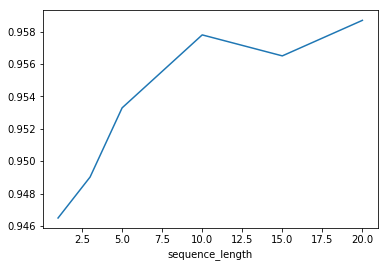

In [19]:
results.groupby("sequence_length").agg('max')['fit_val_acc'].plot()

In [35]:
grp = results.groupby(["sequence_model","sequence_length"]).agg("max")['fit_val_acc'].unstack()
grp

sequence_length,5.0,10.0,3.0,15.0,20.0
sequence_model,,,,,
Convolution1D,0.936084,0.877953,NaN,NaN,NaN
GRU,0.952180,0.956125,0.948178,0.953596,0.954195
LSTM,0.952983,0.957799,0.949024,0.956503,0.958697
SimpleRNN,0.953295,0.957509,0.947108,0.955229,0.958317


(-0.5, 3.5, 0.85, 1)

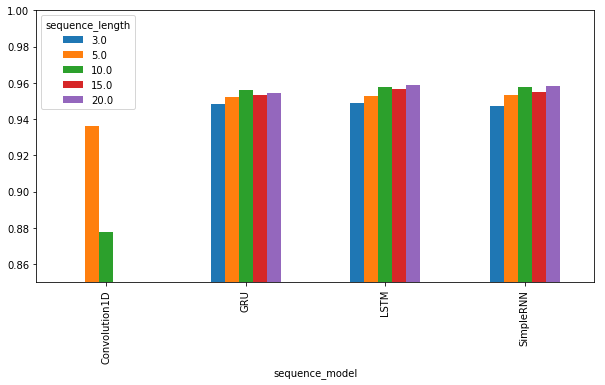

In [36]:
# sort cols
grpcols = list(grp.columns)
grpcols.sort()
grp = grp[grpcols]
# plot
plt = grp.plot(kind='bar', figsize=(10,5))
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.85,1))

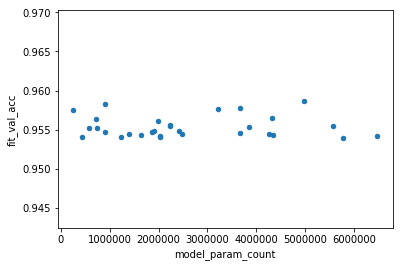

In [40]:
results.sort_values("fit_val_acc",ascending=False).head(30).plot(x='model_param_count',y='fit_val_acc', kind='scatter')

In [21]:
results.sort_values('fit_dt_test_end',ascending=False).head().T

,3092,546,2531,2085,2775
architecture,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen
batch_size,32,32,32,32,32
convolution_kernel_size,3,3,3,3,3
data_total_rows_test,3125,3125,3125,3125,3125
data_total_rows_train,60289,60289,60289,60289,60289
data_total_rows_valid,6388,6388,6388,6388,6388
dropout,0.2,0.2,0.2,0.2,0.2
fit_best_round,3,2,2,3,2
fit_dt_test_duration_seconds,4,3,4,2,2
fit_dt_test_end,2019-01-25 08:57:34,2019-01-25 08:55:13,2019-01-25 08:48:58,2019-01-25 08:47:44,2019-01-25 08:33:14


# re-allocate experiments to workers

In [ ]:
# remove experiments already done
experiments = remove_completed_experiments(experiments)

## re-assign workers on the experiments that are not complete

In [ ]:
# reassign outstanding experiments to workers
experiments = reassign_workers(experiments)

In [ ]:
##################################
### output experiment batch to CSV
##################################
print(experiment_batch_name)
experiments.to_csv(pwd + "experiments/" + experiment_batch_name + '.csv', index=False)

# Debug experiment worker

In [22]:
from deepvideoclassification.architectures import Architecture

In [23]:
WORKER_ID = 0
GPU_ID = 7
experiment_batch_name = 'experiment_batch_2'

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(WORKER_ID)

In [24]:
# setup logging
# separate log file for each worker
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s, [%(levelname)-8s] [%(filename)s:%(lineno)d] %(message)s',
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(pwd, "logs_" + str(WORKER_ID))),
        logging.StreamHandler()
    ])
# init logger - will pass this to our architecture
logger = logging.getLogger()

logger.info("Start worker {} (GPU={}) processing {}".format(WORKER_ID, GPU_ID, experiment_batch_name))

2019-01-25 09:13:00,218 [MainThread  ] [INFO ]  Start worker 0 (GPU=7) processing experiment_batch_2


In [25]:
# load list of experiments
experiments = pd.read_csv(pwd + "experiments/" + experiment_batch_name + '.csv')

In [26]:
experiments[experiments['model_id'].isin([5203, 5240])]

,WORKER,architecture,dropout,layer_1_size,layer_2_size,layer_3_size,model_id,pooling,pretrained_model_name,sequence_length,sequence_model,sequence_model_layers
1,2,video_LRCNN_frozen,0.2,128,128,128,5203,max,resnet50,10,SimpleRNN,2.0
3,4,video_LRCNN_frozen,0.2,128,0,0,5240,max,resnet50,10,LSTM,1.0


In [27]:
# for row in experiments.values:
debug_model_id = 5203

row = list(experiments[experiments['model_id'] == debug_model_id].values[0])

# get experiment params from dataframe row
experiment = dict(zip(experiments.columns, row))

In [28]:
experiment

{'WORKER': 2,
 'architecture': 'video_LRCNN_frozen',
 'dropout': 0.2,
 'layer_1_size': 128,
 'layer_2_size': 128,
 'layer_3_size': 128,
 'model_id': 5203,
 'pooling': 'max',
 'pretrained_model_name': 'resnet50',
 'sequence_length': 10,
 'sequence_model': 'SimpleRNN',
 'sequence_model_layers': 2.0}

In [29]:
experiments[experiments['model_id'] == debug_model_id].T

,1
WORKER,2
architecture,video_LRCNN_frozen
dropout,0.2
layer_1_size,128
layer_2_size,128
layer_3_size,128
model_id,5203
pooling,max
pretrained_model_name,resnet50
sequence_length,10


In [30]:
print(str(experiment["model_id"]) + "   " + "X"*60)
logging.info("Begin experiment for model_id={} on GPU:{} ".format(experiment['model_id'], os.environ["CUDA_VISIBLE_DEVICES"]))
print(experiment)

architecture = Architecture(model_id = experiment['model_id'], 
                            architecture = experiment['architecture'], 
                            sequence_length = experiment['sequence_length'], 
                            pretrained_model_name = experiment['pretrained_model_name'],
                            pooling = experiment['pooling'],
                            sequence_model = experiment['sequence_model'],
                            sequence_model_layers = experiment['sequence_model_layers'],
                            layer_1_size = experiment['layer_1_size'],
                            layer_2_size = experiment['layer_2_size'],
                            layer_3_size = experiment['layer_3_size'],
                            dropout = experiment['dropout'],
                            verbose=True)

2019-01-25 09:13:03,927 [MainThread  ] [INFO ]  Begin experiment for model_id=5203 on GPU:0 
2019-01-25 09:13:03,930 [MainThread  ] [INFO ]  Model folder exists but no results found - potential error in previous model training
2019-01-25 09:13:03,931 [MainThread  ] [INFO ]  Loading data


5203   XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
{'WORKER': 2, 'layer_3_size': 128, 'sequence_model_layers': 2.0, 'layer_2_size': 128, 'pooling': 'max', 'sequence_length': 10, 'architecture': 'video_LRCNN_frozen', 'layer_1_size': 128, 'dropout': 0.2, 'model_id': 5203, 'pretrained_model_name': 'resnet50', 'sequence_model': 'SimpleRNN'}


2019-01-25 09:13:05,020 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/resnet50/max/
2019-01-25 09:13:05,021 [MainThread  ] [INFO ]  Loading features sequence data into memory [may take a few minutes]


Done initializing data with #samples: train=60399, valid=6398, test=3130


In [ ]:
architecture.train_model(epochs=1)


Epoch 00001: val_acc improved from -inf to 0.94925, saving model to /mnt/seals/models/5203/model_round_1.h5
H1 {'loss': [0.1535637148673113], 'acc': [0.9371205471454447], 'val_loss': [0.14657298705612506], 'val_acc': [0.9492475513034628]}
stopped_epoch1 0
1
0.9492475513034628
